In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
import importlib
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)


Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')
['SOLV', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')



Null values: False
NaN values: False

Creating features
The dataset has 485 assets
The dataset has 14 predictors:
Ticker
Yavg_return
Yavg_volatility
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



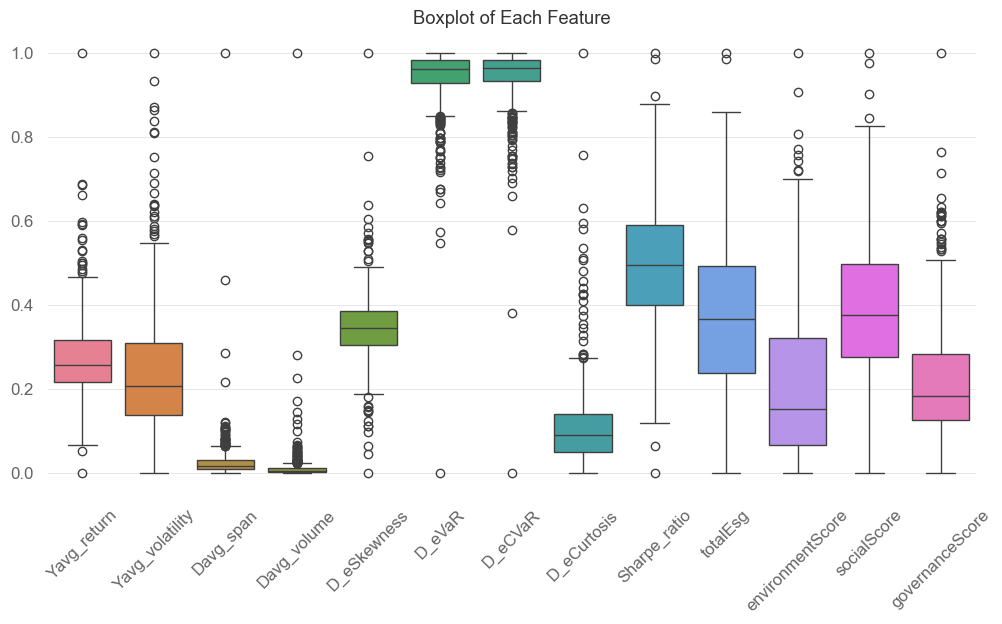

In [3]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(12, 6))
scaled_data = pd.DataFrame()
for attr in dataset.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(dataset[attr].values.reshape(-1, 1)).flatten()
sns.boxplot(data=scaled_data)

# Customize labels
plt.xticks(rotation=45)  # Rotate feature names if needed
plt.title("Boxplot of Each Feature")
plt.show()

Removed 13 observations


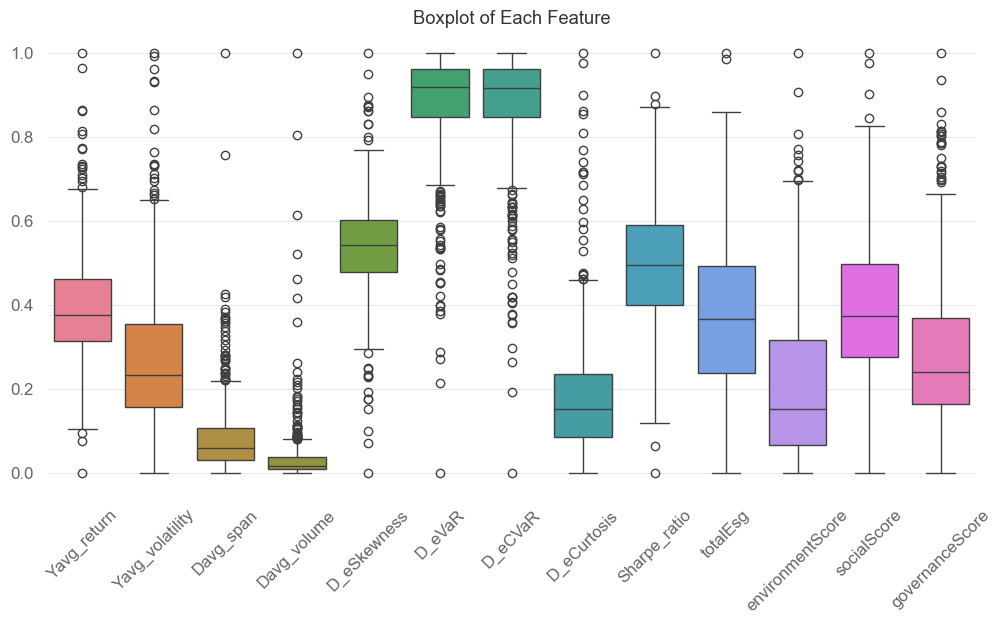

In [4]:
from scipy.spatial.distance import cdist
threshold = 0.1  # Distance threshold

# Convert DataFrame to NumPy array for efficient computation
data = scaled_data.values
n_samples, n_features = data.shape

# Boolean mask to track which rows to keep
rows_to_keep = np.ones(n_samples, dtype=bool)

# Iterate over rows
for i in range(n_samples):
    for j in range(n_features):
        # Compute distances for the current feature (ignoring self-comparison)
        distances = np.abs(data[:, j] - data[i, j])
        distances[i] = np.inf  # Ignore self-distance

        # If no value is within threshold, mark row for deletion
        if not np.any(distances < threshold):
            rows_to_keep[i] = False
            break  # No need to check other features, remove row immediately

# Filter DataFrame
filtered_df = dataset[rows_to_keep]
print(f"Removed {len(dataset)-len(filtered_df)} observations")
plt.figure(figsize=(12, 6))
scaled_data = pd.DataFrame()
for attr in filtered_df.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(filtered_df[attr].values.reshape(-1, 1)).flatten()
sns.boxplot(data=scaled_data)

# Customize labels
plt.xticks(rotation=45)  # Rotate feature names if needed
plt.title("Boxplot of Each Feature")
plt.show()

In [5]:
final_dataframe = dataset[rows_to_keep]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry
0,A,0.170254,0.290318,2.268208,1.961764e+06,-0.134993,-0.000283,-0.000401,4.334457,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services
1,AAPL,0.309906,0.316770,2.378506,1.073273e+08,-0.036494,-0.000292,-0.000426,4.924367,0.915194,16.79,0.55,7.52,8.72,Technology
2,ABBV,0.159055,0.273195,2.003774,7.196053e+06,-0.845043,-0.000286,-0.000483,13.941181,0.508994,26.10,1.78,15.70,8.62,Biotechnology
3,ABT,0.155088,0.257788,1.733056,5.701730e+06,0.048213,-0.000290,-0.000434,6.096857,0.524026,22.21,1.81,13.84,6.56,Health Care
4,ACGL,0.204344,0.314158,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance


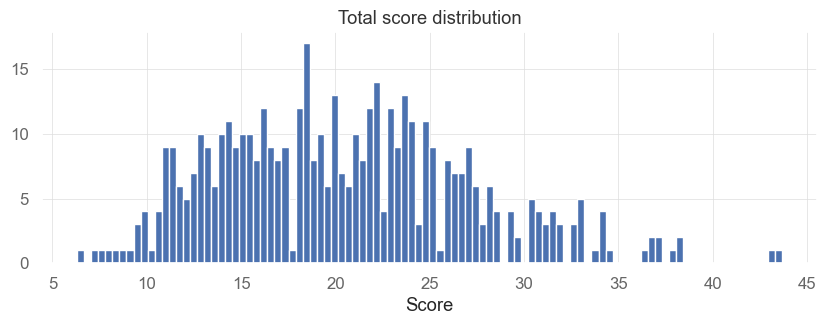

In [6]:
plt.figure(figsize=(10,3))
# stock_data["totalEsg"].value_counts().plot(kind="hist", bins=10)
plt.hist(final_dataframe["totalEsg"], bins=100)
plt.title("Total score distribution")
plt.xlabel("Score")
plt.show()

In [7]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 0 to 484
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ticker            472 non-null    object 
 1   Yavg_return       472 non-null    float64
 2   Yavg_volatility   472 non-null    float64
 3   Davg_span         472 non-null    float64
 4   Davg_volume       472 non-null    float64
 5   D_eSkewness       472 non-null    float64
 6   D_eVaR            472 non-null    float64
 7   D_eCVaR           472 non-null    float64
 8   D_eCurtosis       472 non-null    float64
 9   Sharpe_ratio      472 non-null    float64
 10  totalEsg          472 non-null    float64
 11  environmentScore  472 non-null    float64
 12  socialScore       472 non-null    float64
 13  governanceScore   472 non-null    float64
 14  industry          387 non-null    object 
dtypes: float64(13), object(2)
memory usage: 59.0+ KB


In [17]:
stock_data_clustering = final_dataframe.copy()
for attr in filtered_df.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(final_dataframe[attr].values.reshape(-1, 1)).flatten()

# for type, feature in zip(stock_data.dtypes, stock_data.columns):
#     if type == "object" and feature!="Ticker":
#         stock_data_clustering[feature] = stock_data[feature].astype('category').cat.codes
# stock_data = stock_data.dropna()
stock_data_clustering = stock_data_clustering.drop(columns=["Ticker", "industry", "Sharpe_ratio"])
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 0 to 484
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Yavg_return       472 non-null    float64
 1   Yavg_volatility   472 non-null    float64
 2   Davg_span         472 non-null    float64
 3   Davg_volume       472 non-null    float64
 4   D_eSkewness       472 non-null    float64
 5   D_eVaR            472 non-null    float64
 6   D_eCVaR           472 non-null    float64
 7   D_eCurtosis       472 non-null    float64
 8   totalEsg          472 non-null    float64
 9   environmentScore  472 non-null    float64
 10  socialScore       472 non-null    float64
 11  governanceScore   472 non-null    float64
dtypes: float64(12)
memory usage: 47.9 KB


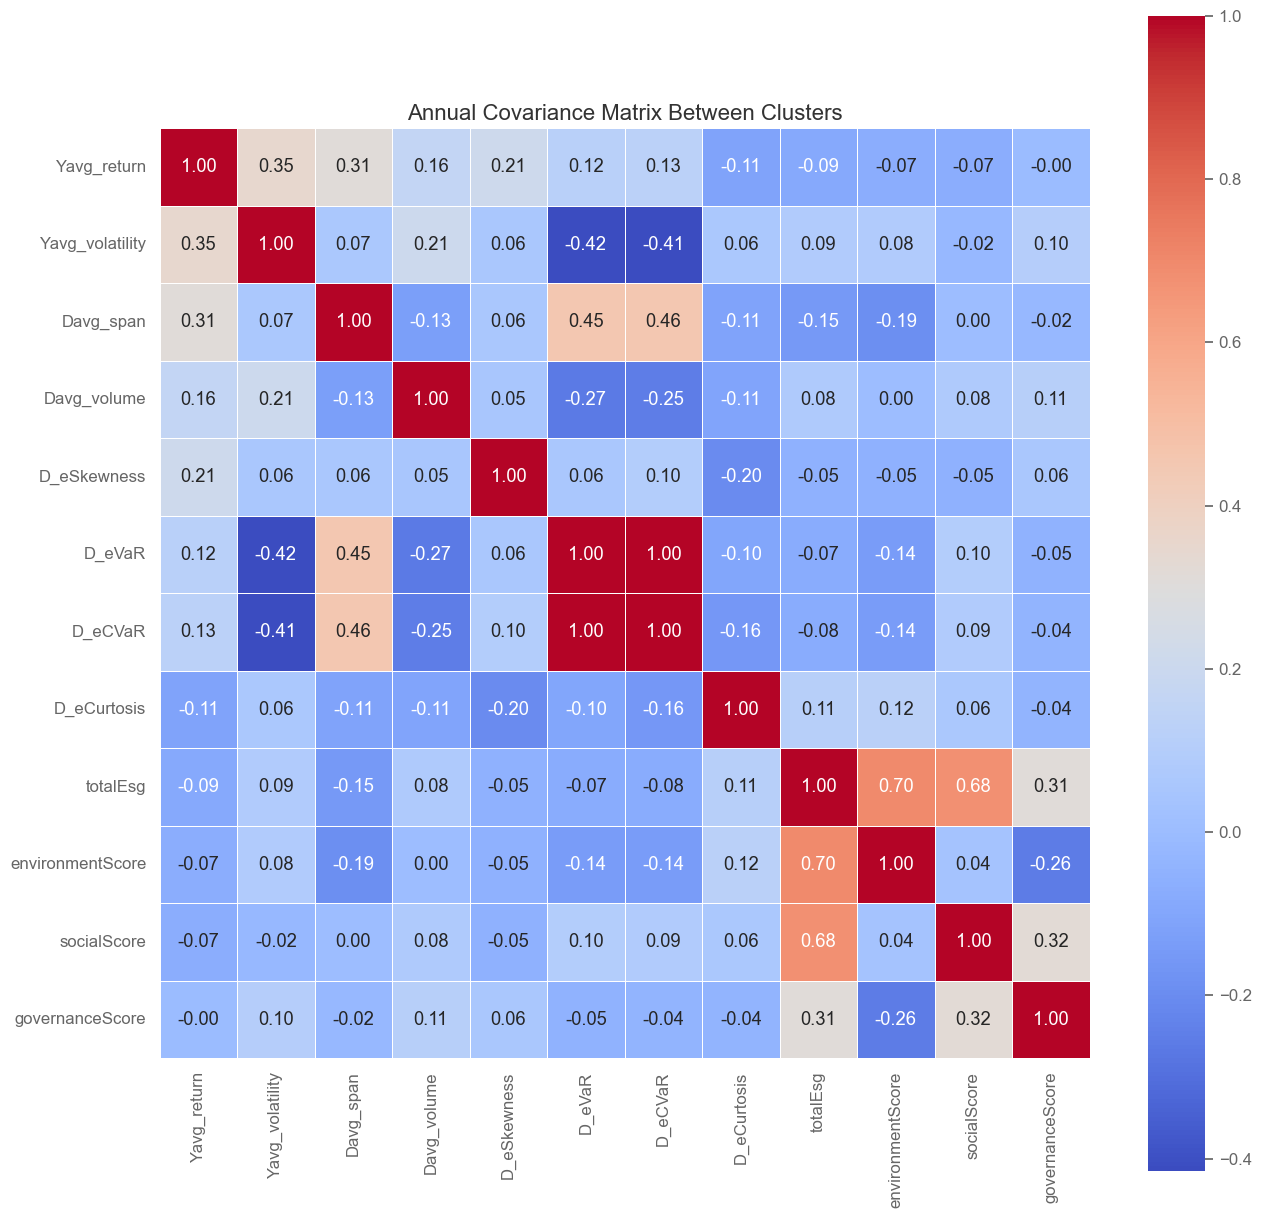

In [18]:
import seaborn as sns
correlation = stock_data_clustering.corr()
plt.figure(figsize=(15, 15))  
sns.heatmap(
    correlation, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".2f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Annual Covariance Matrix Between Clusters", fontsize=16)
plt.show()

In [19]:
useless = ["D_eVaR"]
stock_data_clustering = stock_data_clustering.drop(columns=useless)

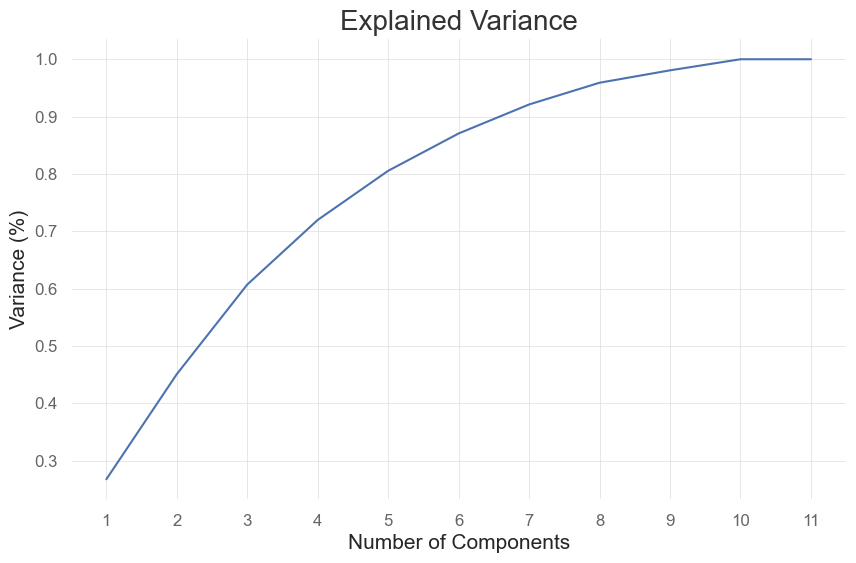

In [20]:
from sklearn.decomposition import PCA

# pass through the scaled data set into our PCA class object
pca = PCA().fit(stock_data_clustering)

# plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.arange(1,12), np.cumsum(pca.explained_variance_ratio_))

# define the labels & title
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15) 
plt.title('Explained Variance', fontsize = 20)
plt.xticks(np.arange(1,12))
# show the plot
plt.show()

In [30]:
n= 7
pca_dataset = PCA(n_components=n).fit(stock_data_clustering).transform(stock_data_clustering)

# store it in a new data frame
pca_dataset= pd.DataFrame(data = pca_dataset, columns = [f'principal component {i+1}' for i in range(n)])

In [31]:
from analysis.clustering.kmeans_clustering import run_kmeans
clusters = range(2, 20)
runs = 60
meanDistortions, sil_score, inertias = run_kmeans(clusters, pca_dataset, runs)

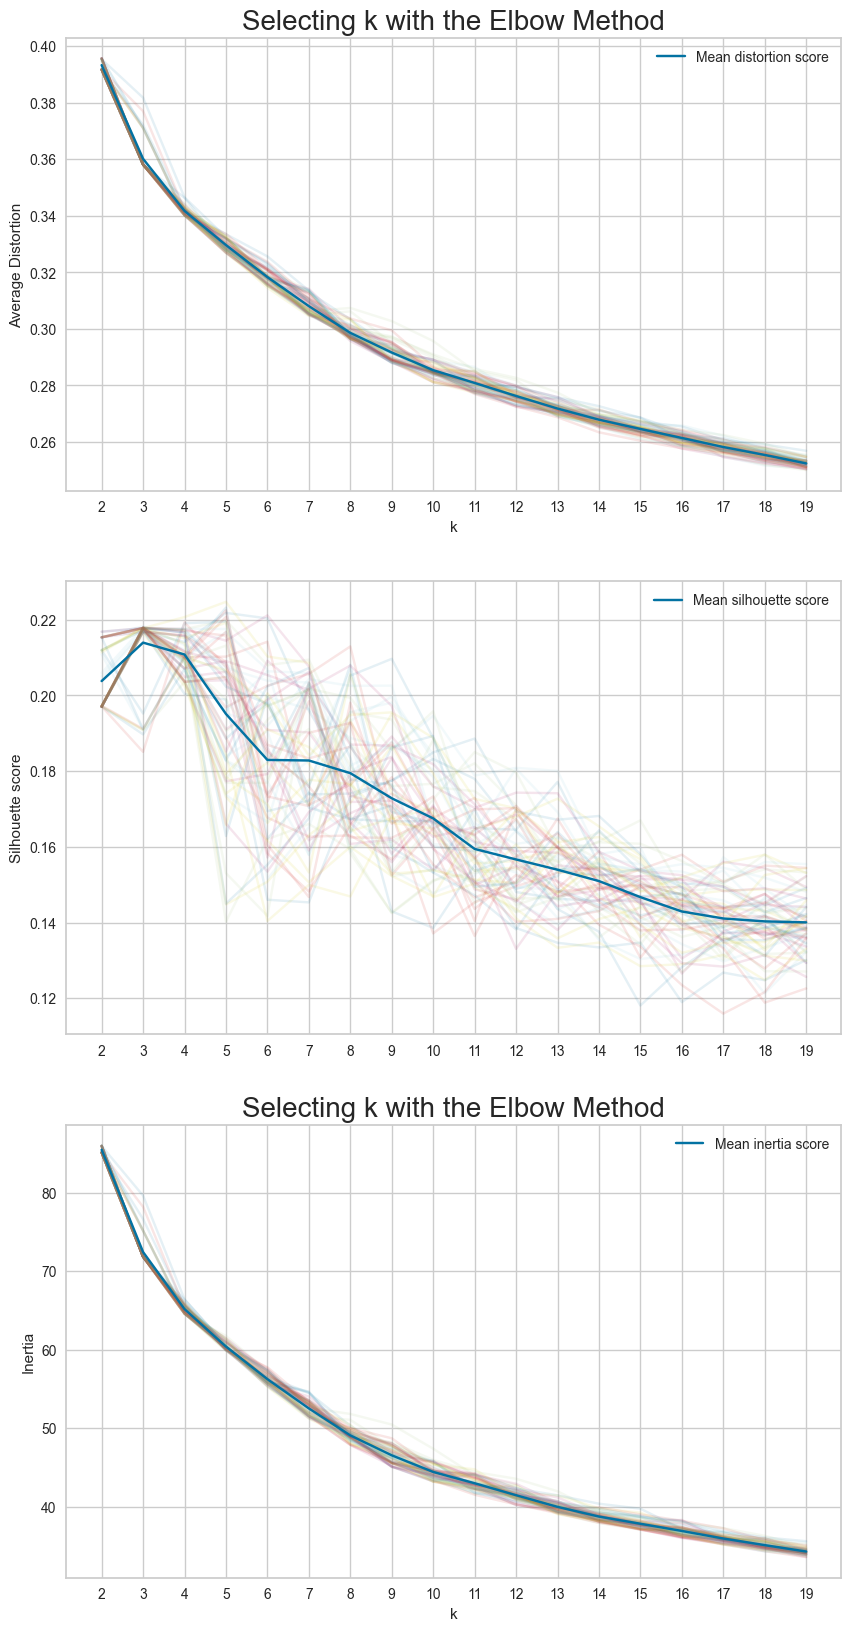

In [32]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

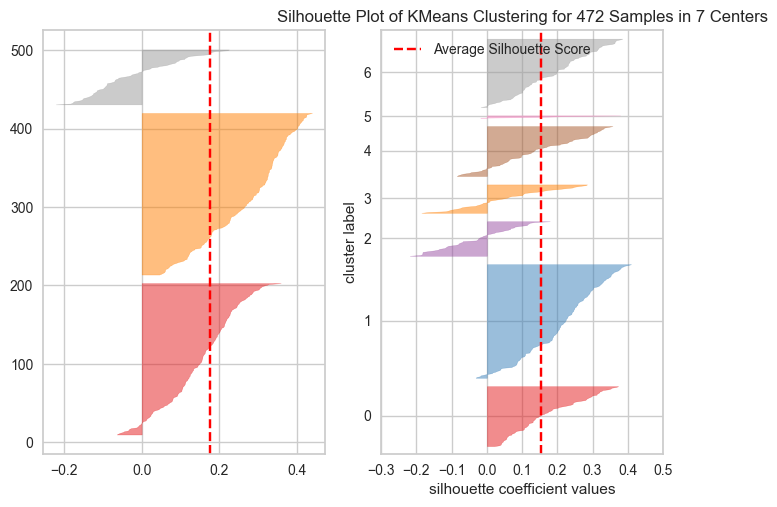

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 472 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [35]:
N_SECTORS = 3

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(pca_dataset)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()


,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry,Sector
0,A,0.170254,0.290318,2.268208,1.961764e+06,-0.134993,-0.000283,-0.000401,4.334457,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,0
1,AAPL,0.309906,0.316770,2.378506,1.073273e+08,-0.036494,-0.000292,-0.000426,4.924367,0.915194,16.79,0.55,7.52,8.72,Technology,2
2,ABBV,0.159055,0.273195,2.003774,7.196053e+06,-0.845043,-0.000286,-0.000483,13.941181,0.508994,26.10,1.78,15.70,8.62,Biotechnology,2
3,ABT,0.155088,0.257788,1.733056,5.701730e+06,0.048213,-0.000290,-0.000434,6.096857,0.524026,22.21,1.81,13.84,6.56,Health Care,2
4,ACGL,0.204344,0.314158,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance,2


In [36]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]
cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,
0,0.179645,0.344681,3.625930,3856380.671344,-0.082513,-0.000523,-0.000822,10.965771,0.463167,15.071928,3.904395,6.711749,4.455426,223
1,0.138628,0.334564,2.178745,5552695.412828,-0.145395,-0.000661,-0.001058,13.606987,0.354574,27.581986,11.785745,10.793333,5.002908,141
2,0.151634,0.340679,2.806089,7570569.287522,-0.113343,-0.000576,-0.000912,10.972154,0.386387,22.041389,1.992407,11.480833,8.568704,108


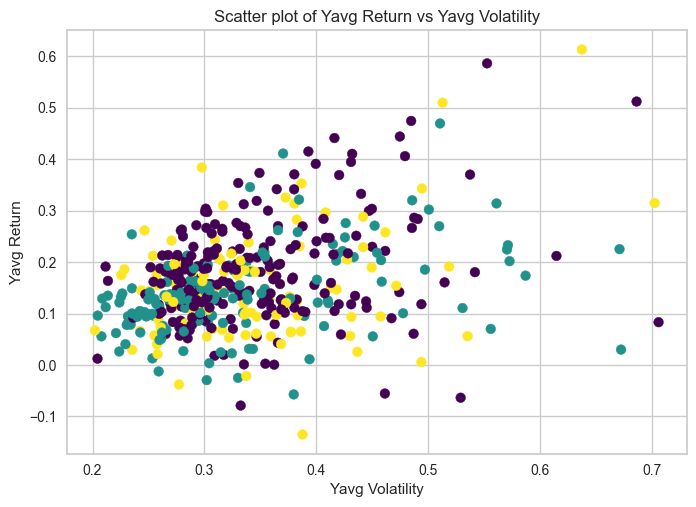

In [37]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis'  # Optional: Choose a colormap
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")

# Show the plot
plt.show()

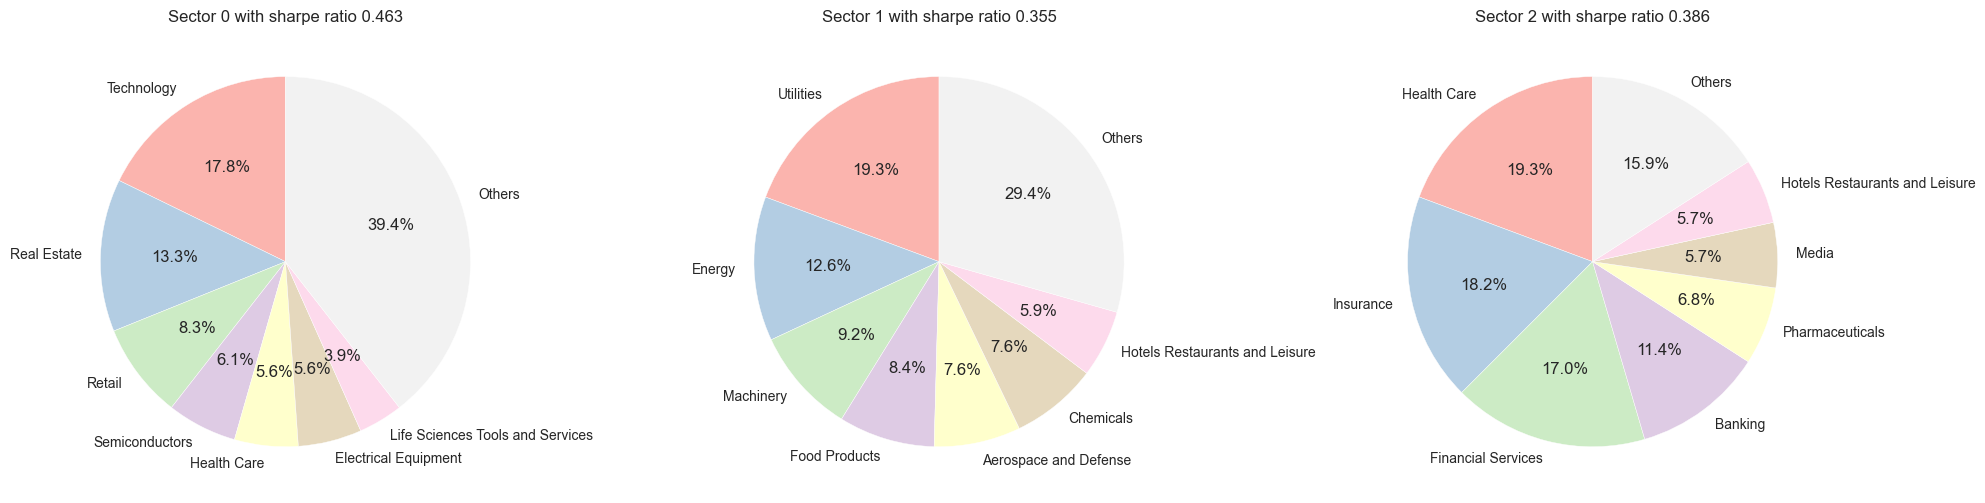

In [39]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)

In [47]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w="sharpe")

[*********************100%***********************]  472 of 472 completed


Null values: False
Null values: False


In [48]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


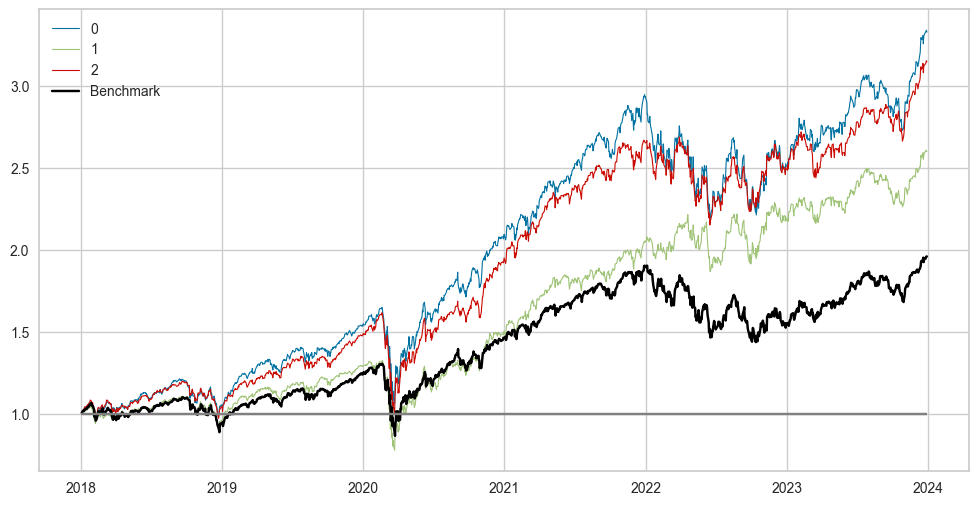

In [42]:
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret, benchmark)

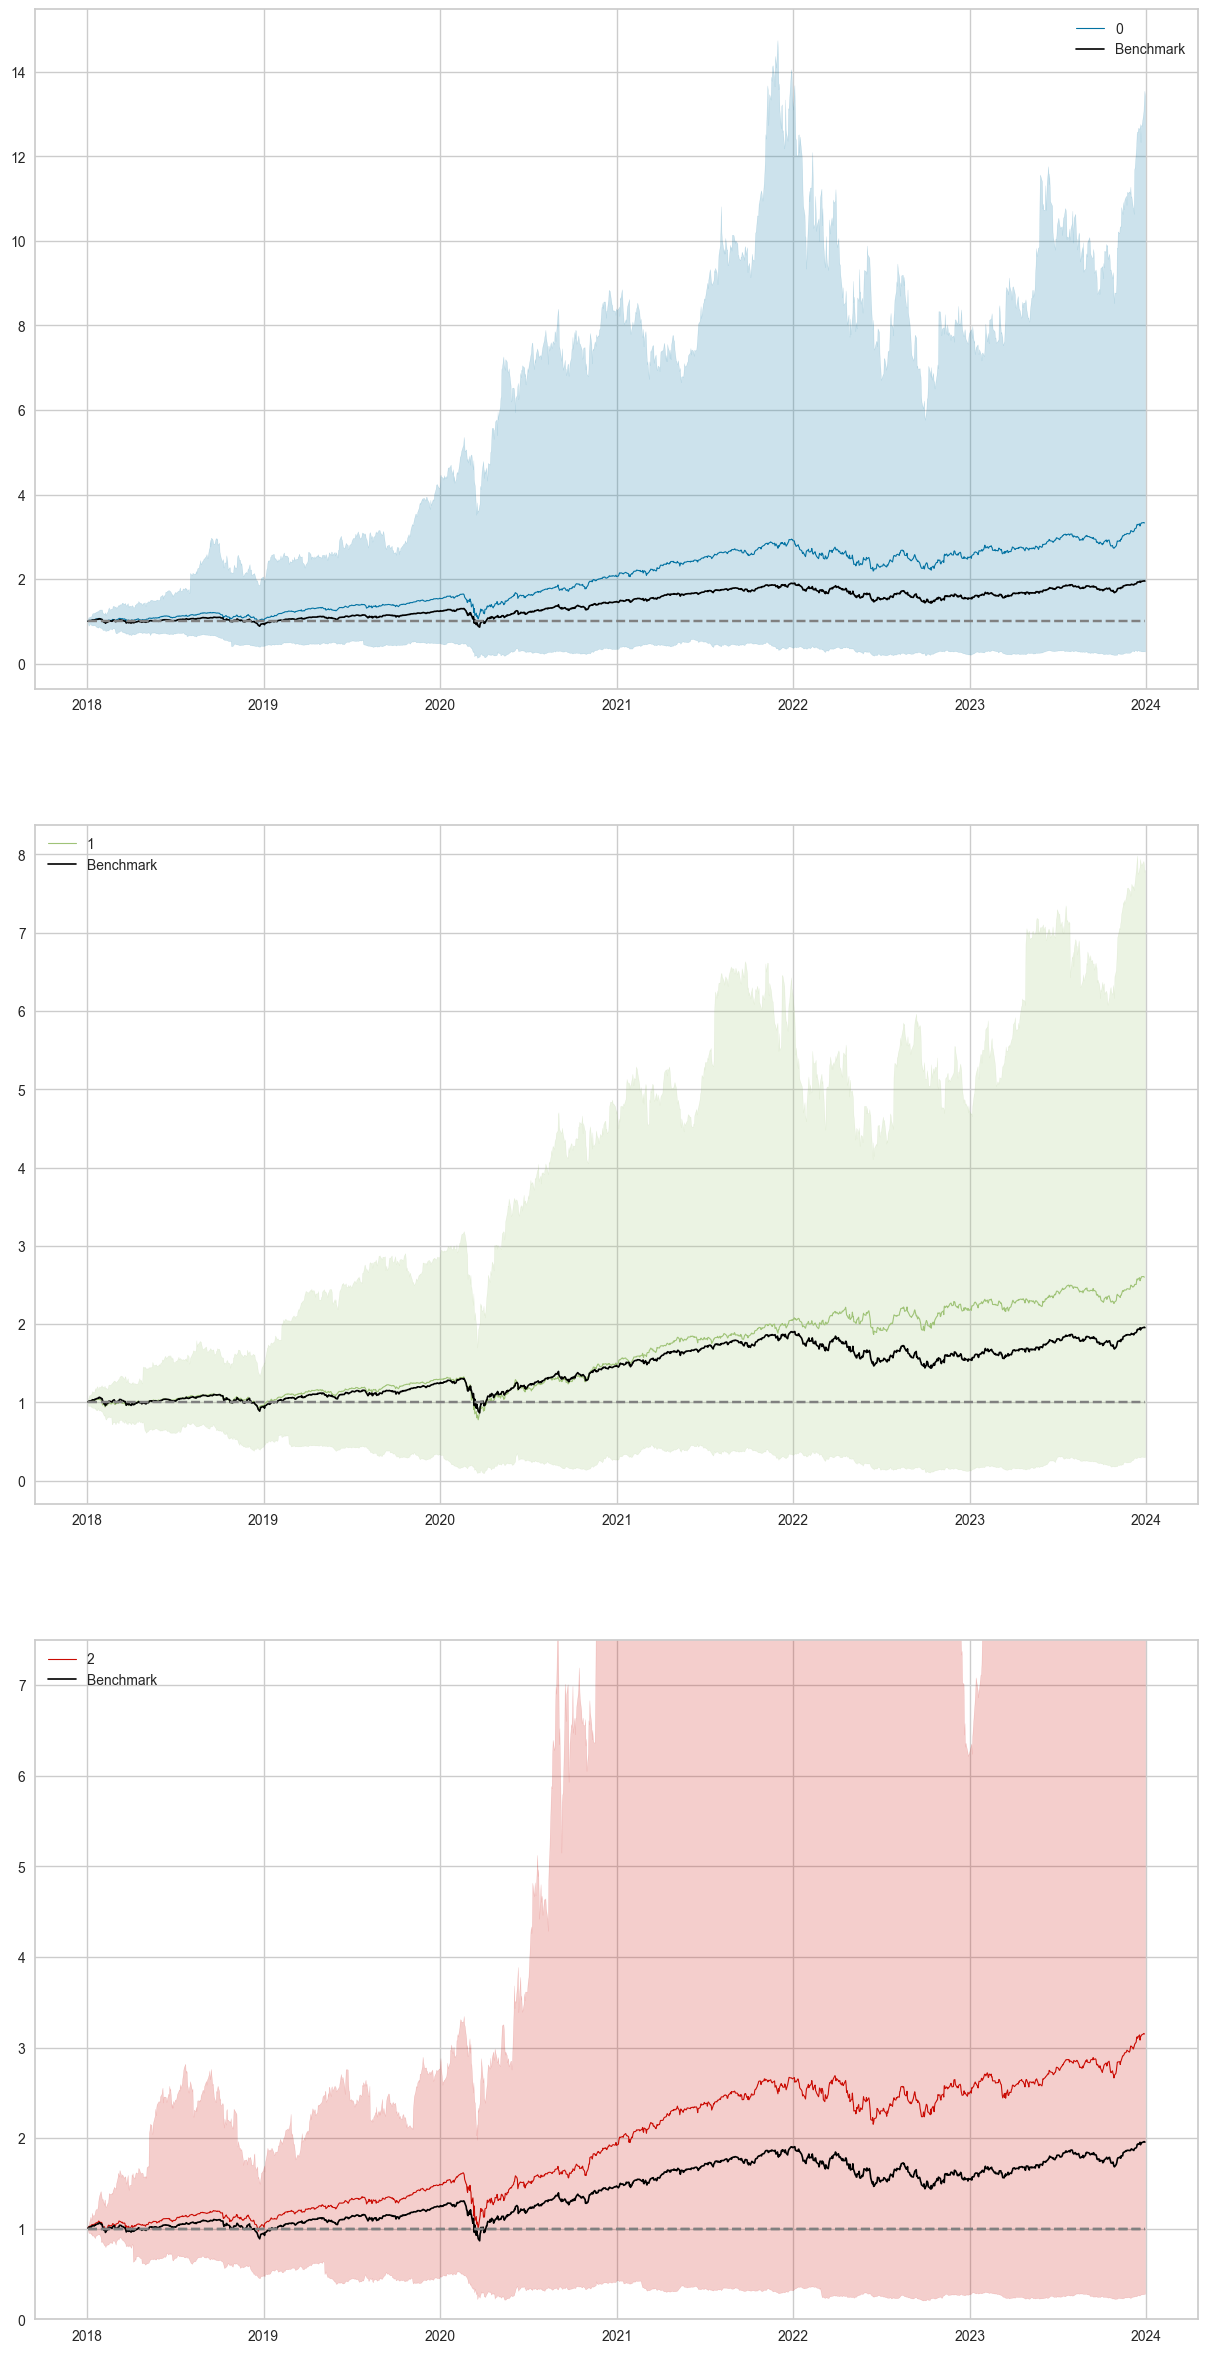

In [43]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)

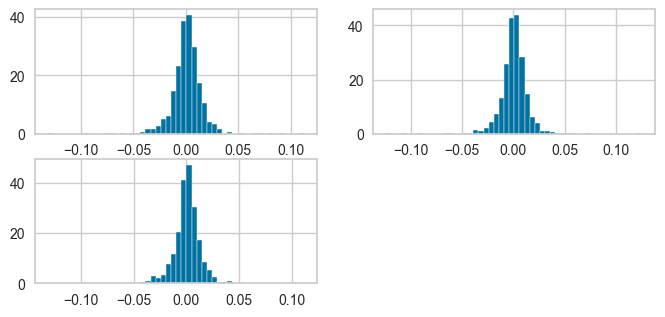

In [44]:
plots = len(portfolio_ret.columns)
for i in range(plots):
    plt.subplot(3,2,i+1)
    plt.hist(portfolio_ret[i], bins=50, density=True)
plt.show()


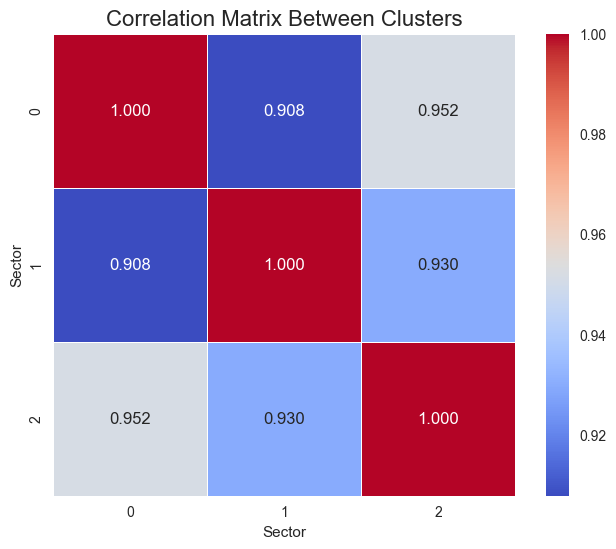

In [45]:
cor_matrix = portfolio_ret.corr()

# 2. Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(
    cor_matrix, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".3f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Correlation Matrix Between Clusters", fontsize=16)
plt.show()

In [49]:
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe, list(final_dataframe["Ticker"]), w="sharpe")

[*********************100%***********************]  472 of 472 completed


Null values: False
Null values: False


In [50]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [51]:
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

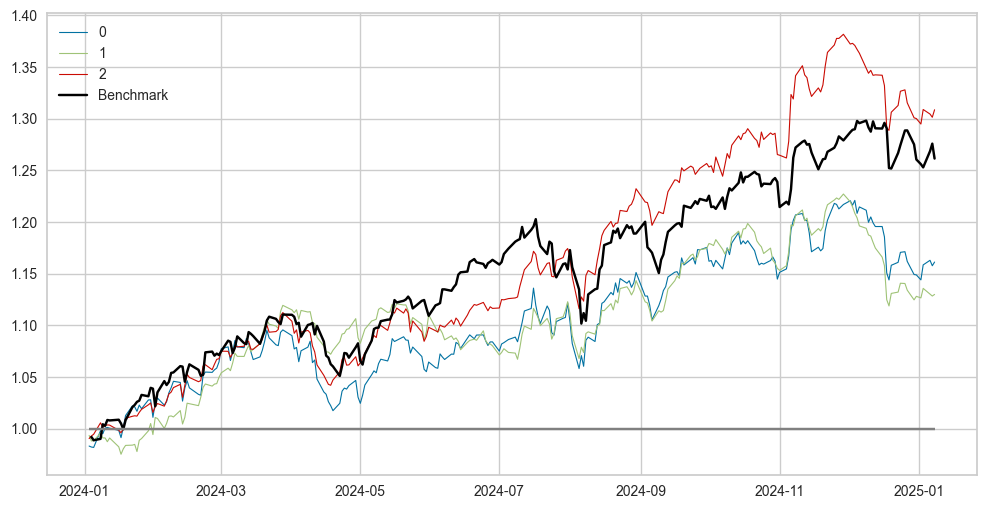

In [55]:
portfolio_evolution_time(portfolio_ret_t, benchmark_t)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-08   2025-01-08
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          27.36%       21.15%
CAGR﹪                     17.91%       13.96%

Sharpe                     1.81         1.52
Prob. Sharpe Ratio         94.51%       91.15%
Smart Sharpe               1.68         1.41
Sortino                    2.61         2.23
Smart Sortino              2.42         2.07
Sortino/√2                 1.85         1.57
Smart Sortino/√2           1.71         1.46
Omega                      1.28         1.28

Max Drawdown               -8.41%       -6.95%
Longest DD Days            64           101
Volatility (ann.)          12.57%       11.65%
R^2                        0.79         0.79
Information Ratio          -0.06        -0.06
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2024-12-19,2025-01-08,38,-6.952462,-6.648867
2,2024-04-01,2024-04-18,2024-07-10,101,-5.948776,-5.919379
3,2024-07-17,2024-08-05,2024-08-16,31,-5.570840,-5.159828
4,2024-09-03,2024-09-06,2024-09-13,11,-3.504175,-2.424189
5,2024-10-21,2024-10-31,2024-11-05,16,-2.897271,-2.710741


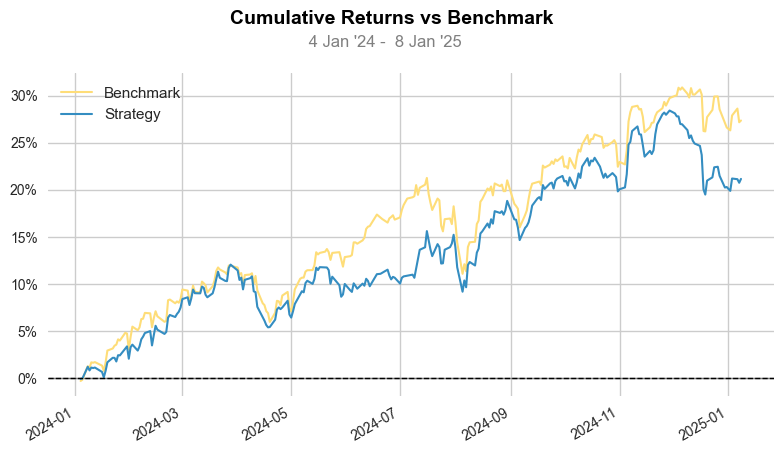

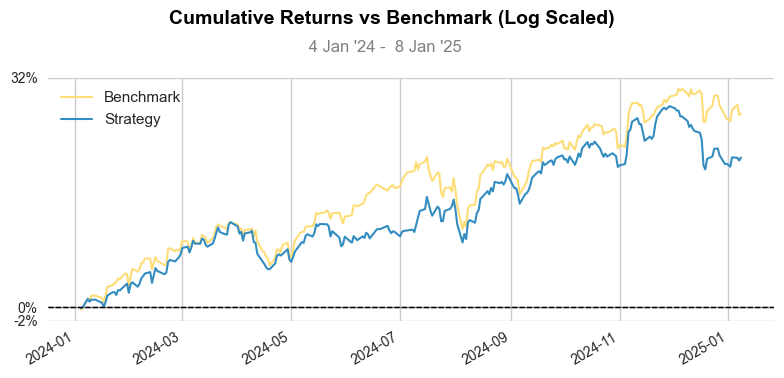

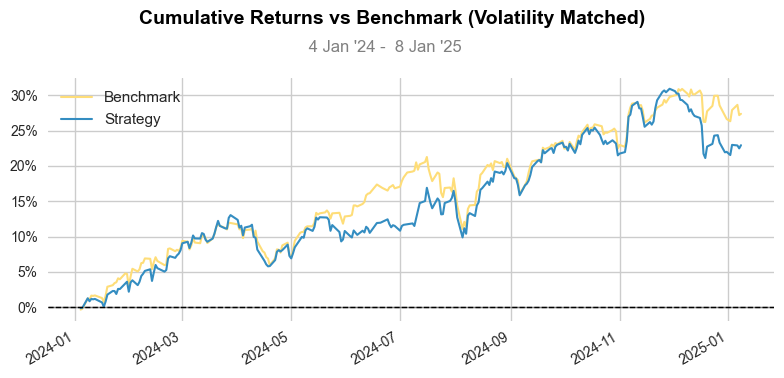

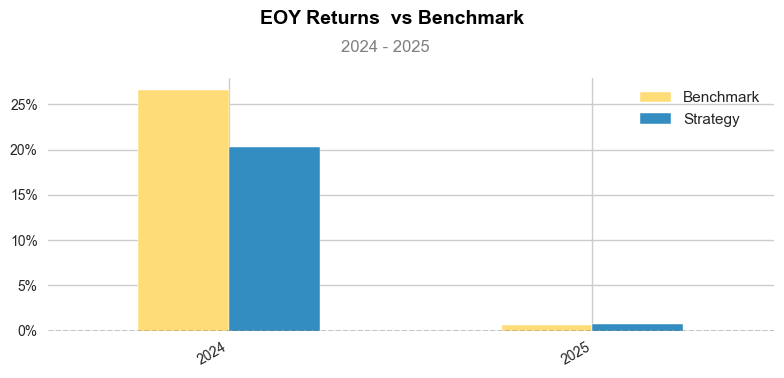

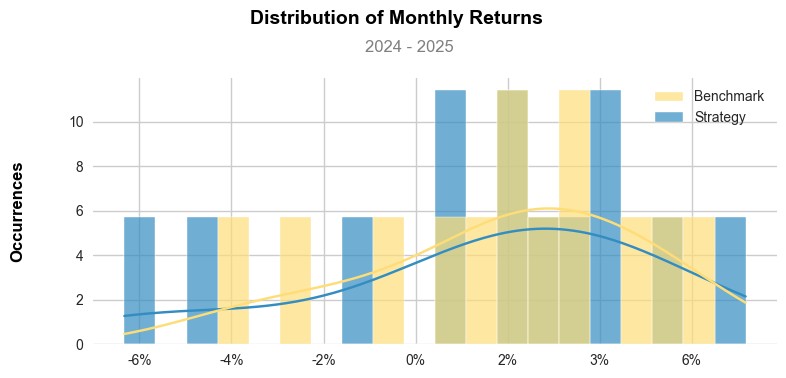

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [54]:
import quantstats as qs

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 2, 0.1).values[0]
        returns += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()

portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark='SPY', rf=0.02)